### Load Dependencies

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import numpy as np
import copy
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing
from ExtractBootlegFeatures import *

### Cython DTW

In [3]:
dtw_steps = [1,1,1,2,2,1] # dtw
dtw_weights = [1,1,2]

In [4]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [5]:
def alignBootlegScores(query, ref, numRefNotes, steps = [1,1,1,2,2,1], weights = [1,1,2], optimized=True):
    if optimized: # Cython implementation
        # set params
        assert len(steps) % 2 == 0, "The length of steps must be even."
        dn = np.array(steps[::2], dtype=np.uint32)
        dm = np.array(steps[1::2], dtype=np.uint32)
        dw = weights
        subsequence = True
        parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

        # Compute cost matrix
        #cost = costMetric(query.T, ref)
        numQueryNotes = np.sum(query, axis=0)
        cost = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)

        # DTW
        [D, s] = DTW_Cost_To_AccumCostAndSteps(cost, parameter)
        [wp, endCol, endCost] = DTW_GetPath(D, s, parameter)

        # Reformat the output
        wp = wp.T[::-1]
    else: # librosa implementation
        steps = np.array(steps).reshape((-1,2))
        D, wp = lb.sequence.dtw(query, ref, step_sizes_sigma = steps, weights_mul = weights, subseq = True, metric = costMetric)
    return D, wp

### Get Bootleg Score of Query Image

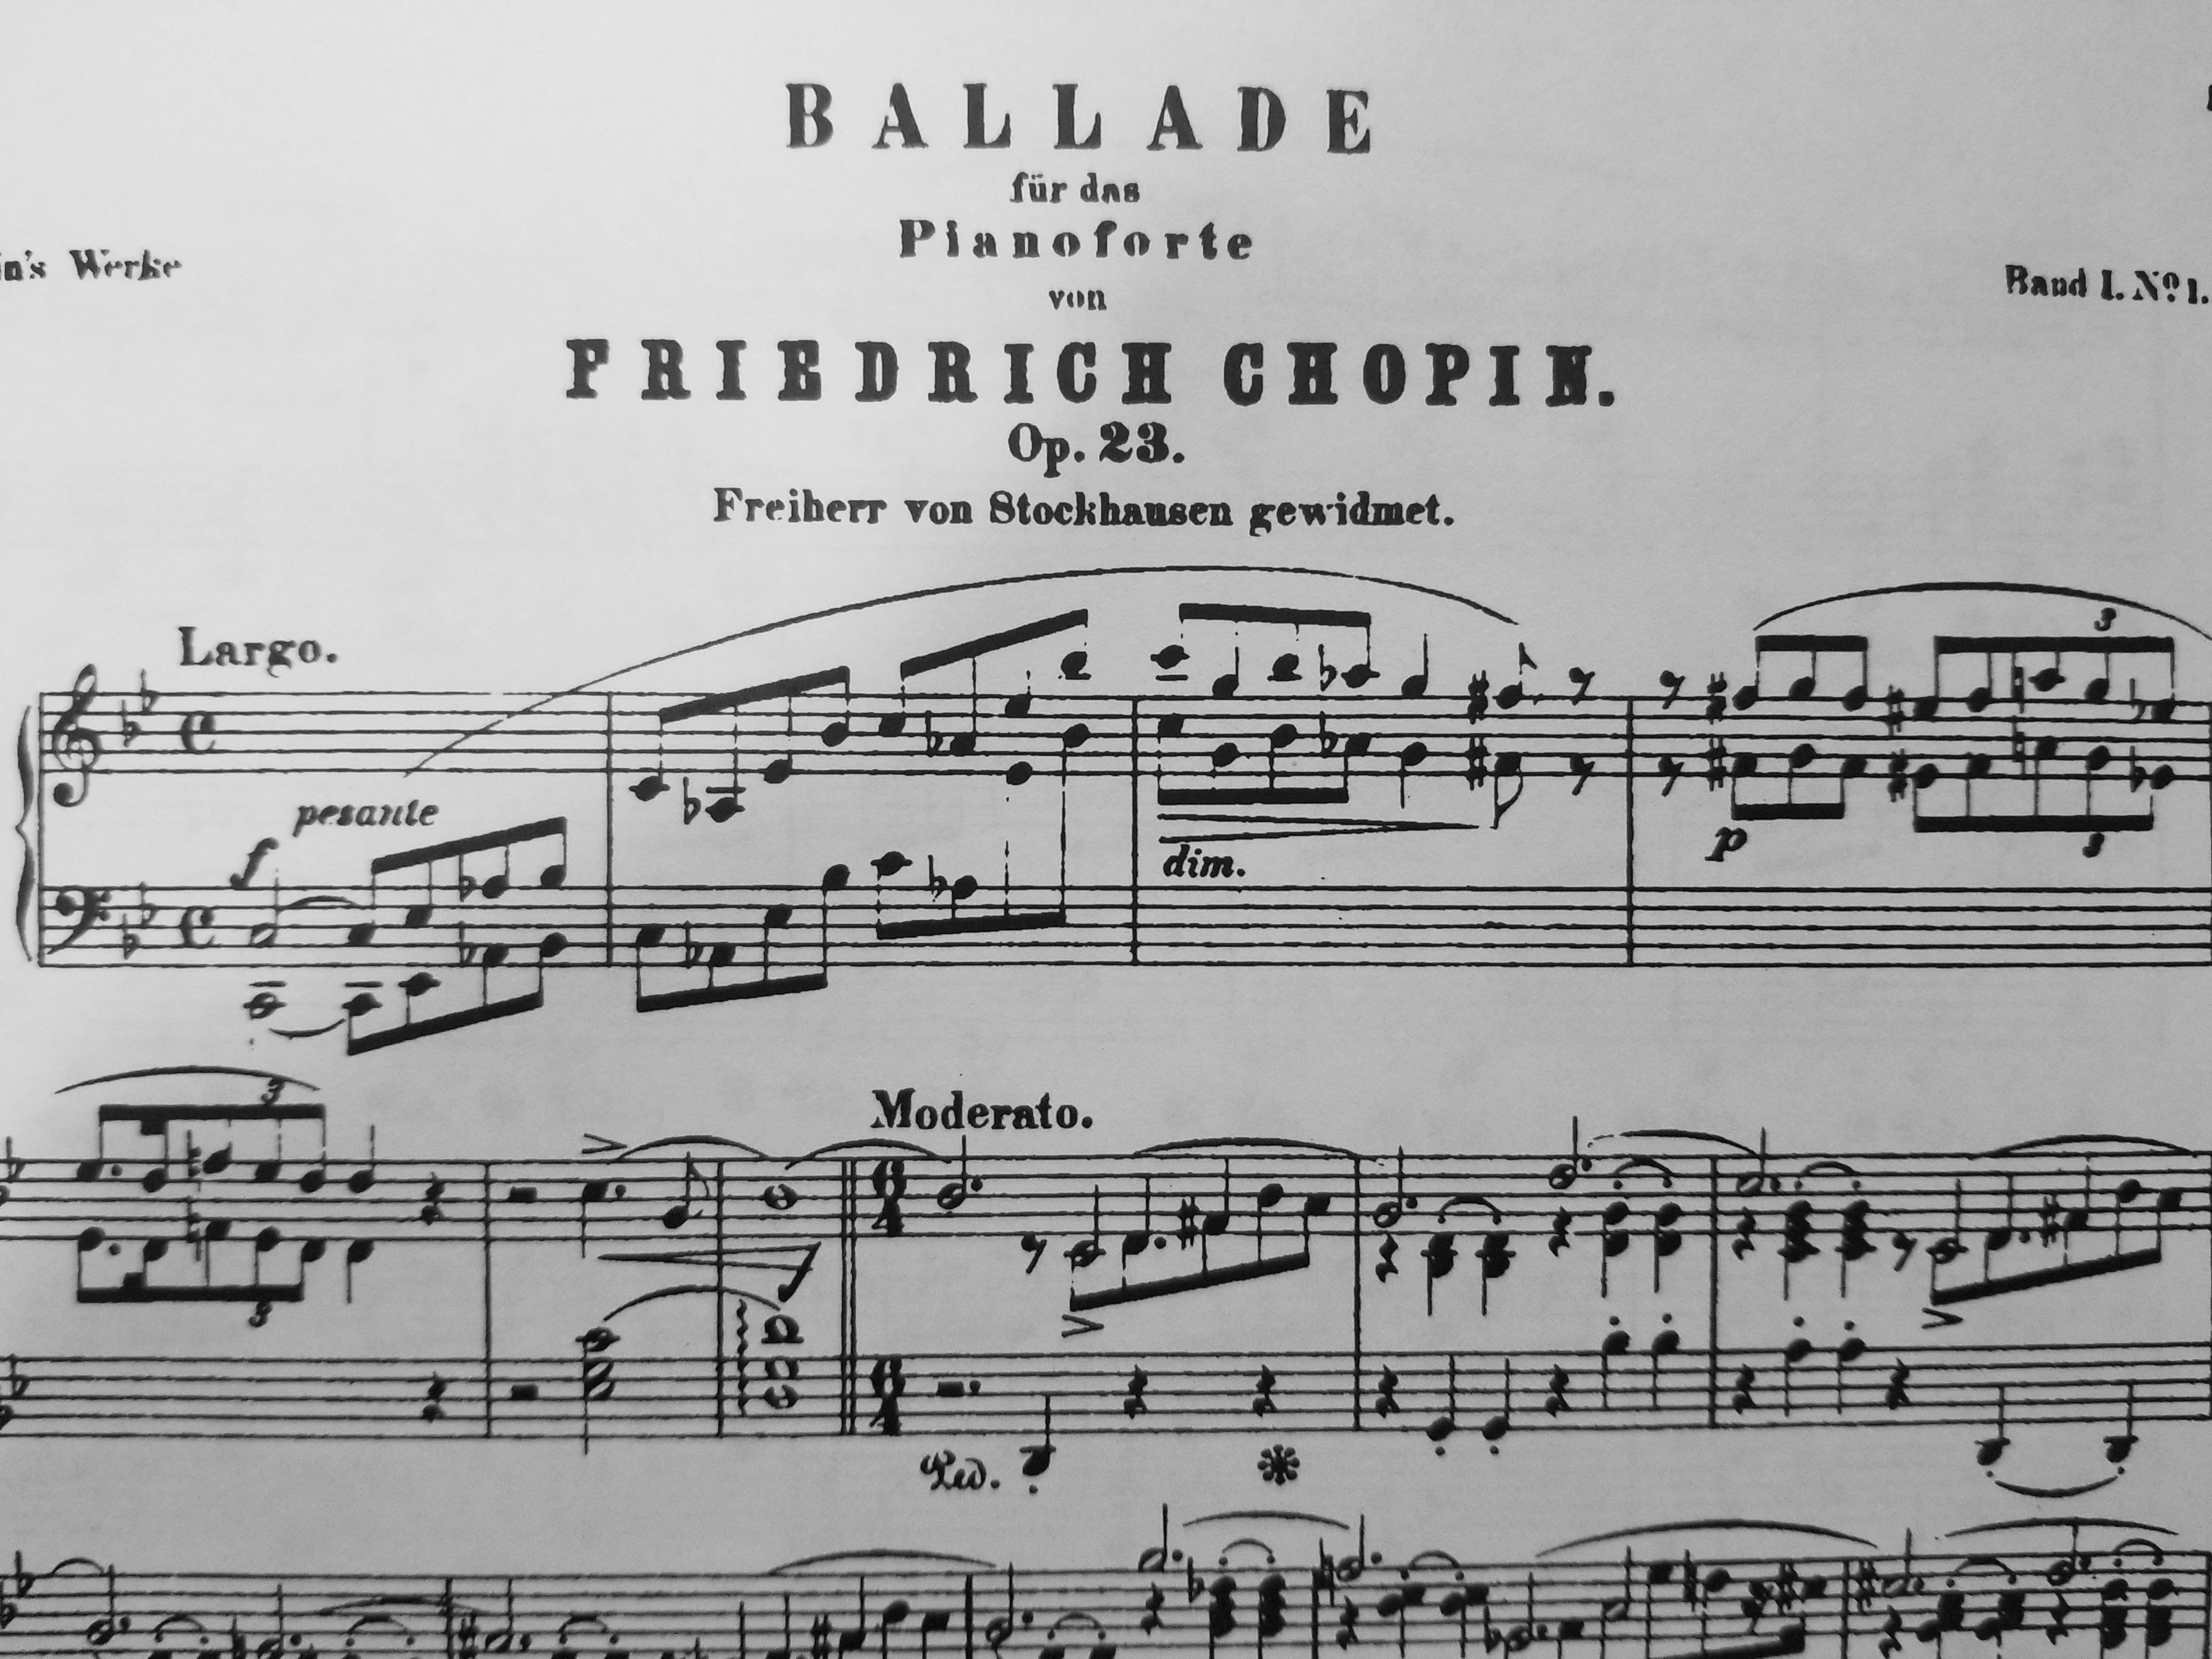

In [3]:
imagefile = 'data/queries/p3_q1.jpg'
pim1 = Image.open(imagefile).convert('L')
pim1

Processing data/queries/p3_q1.jpg


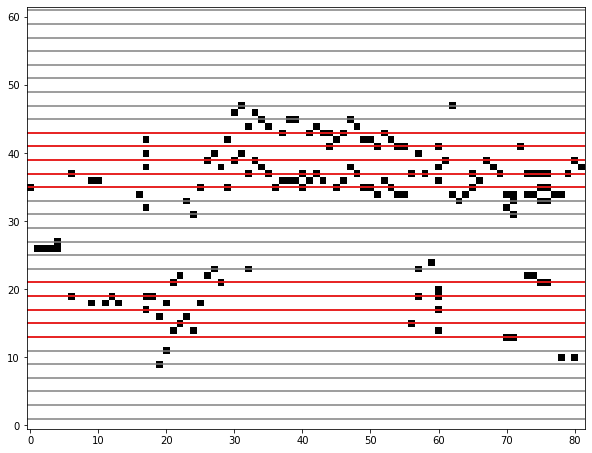

In [4]:
bscore_query=processQuery("data/queries/p3_q1.jpg")
visualizeLongBootlegScore(bscore_query, [13,15,17,19,21,35,37,39,41,43])

### Load Reverse Index

In [5]:
pickle_file = 'G:/experiments/indices/N_Gram_2_ALL.pkl'
with open(pickle_file, 'rb') as f:
    rindex = pickle.load(f)

### Generate Histograms

In [3]:
def bootlegHash(arr):
    bitstring = ""
    for i in range(len(arr)):
        if arr[i]==1:
            bitstring+="1"
        else:
            bitstring +="0"
    bitstring = bitstring+"00"
    hashint = int(bitstring, 2)
    hashint = np.uint64(hashint)
    return hashint

In [4]:
def showHistograms(arr,numBins):
    plt.hist(arr,bins=numBins)
    plt.show()

In [5]:
def getOffsetDelta(bscore_query, rindex):
    offsetDict = {}
    for index in range(len(bscore_query.T)):
        hashkey = bootlegHash(bscore_query.T[index])
        if hashkey ==0 or not hashkey in rindex:
            continue
        rindex_hash = rindex[hashkey]
        #print(len(rindex_hash))
        for key in rindex_hash:
            #DONT USE np.ARRAY
            offset = [i - index for i in rindex_hash[key]]
            if key in offsetDict:
                offsetDict[key].extend(offset)
            else:
                offsetDict[key]=offset
    return offsetDict

In [6]:
def getOffsetDeltaNGram(bscore_query, rindex, N_Gram = 3):
    offsetDict = {}
    for index in range(len(bscore_query.T)):
        hashkey = []
        try:
            for i in range(N_Gram):
                hashkey.append(bootlegHash(bscore_query.T[index+i]))
        except IndexError:
            continue
        hashkey = tuple(hashkey)
        if hashkey == 0 or not hashkey in rindex:
            continue
        rindex_hash = rindex[hashkey]
        for key in rindex_hash:
            #DONT USE np.ARRAY
            offset = [i - index for i in rindex_hash[key]]
            if key in offsetDict:
                offsetDict[key].extend(offset)
            else:
                offsetDict[key]=offset
    return offsetDict

In [5]:
def getOffsetDeltaDynamicStaticN_GRAM(bscore_query, rindex, Max_N = 4):
    offsetDict = {}
    for index in range(len(bscore_query.T)):
        N_Gram = 1
        while(N_Gram <= Max_N):
            hashkey = []
            try:
                for i in range(N_Gram):
                    hashkey.append(bootlegHash(bscore_query.T[index+i]))
            except IndexError:
                break
            hashkey = tuple(hashkey)
            if hashkey in rindex:
                rindex_hash = rindex[hashkey]
                for key in rindex_hash:
                    #DONT USE np.ARRAY
                    offset = [i - index for i in rindex_hash[key]]
                    if key in offsetDict:
                        offsetDict[key].extend(offset)
                    else:
                        offsetDict[key]=offset
                break
            N_Gram+=1
    return offsetDict

In [11]:
def getOffsetDeltaDynamicAdaptiveN_GRAM(bscore_query, rindices, counts, K_total, Max_N = 4):
    # K_avg is the total allocation to each fingerprint
    K_avg = K_total / len(bscore_query.T)
    K_carry = 0
    offsetDict = {}
    for index in range(len(bscore_query.T)):
        N_Gram = 1
        while(True):
            hashkey = []
            try:
                for i in range(N_Gram):
                    hashkey.append(bootlegHash(bscore_query.T[index+i]))
            except IndexError:
                break
            rindex = rindices[N_Gram-1]
            hashkey = tuple(hashkey)
            if not hashkey in rindex:
                break
            numMatches = counts[N_Gram-1][hashkey]
            if numMatches < K_avg + K_carry or N_Gram == Max_N:
                K_carry += K_avg - numMatches
                #NOTE: We try to avoid negative K_carry, but because of the cap in Max_N, we need to be careful.
                rindex_hash = rindex[hashkey]
                for key in rindex_hash:
                    offset = [i - index for i in rindex_hash[key]]
                    if key in offsetDict:
                        offsetDict[key].extend(offset)
                    else:
                        offsetDict[key]=offset
                break
            N_Gram+=1
    return offsetDict

In [6]:
def rankHistograms(offsetDict, rindex, bin_size=5):
    histograms = {}
    bin_size = 10
    pieceScores = []
    numShow = 5
    for key in offsetDict:
        h = offsetDict[key]
        maxh = max(h)
        minh = min(h)
        if(maxh > minh+bin_size):
            hist = [0 for i in range(int((maxh-minh)/bin_size)+1)]
            for i in h:
                hist[int((i-minh)/bin_size)]+=1
            score = max(hist)
            pieceScores.append((key, score))    
            histograms[key]=(h,len(set(h)))
            
    pieceScores = sorted(pieceScores, key = lambda x:x[1], reverse=True)
    return pieceScores, histograms



In [13]:
start = time.process_time()
offsetDict = getOffsetDeltaNGram(bscore_query, rindex, 2)
pieceScores, histograms = rankHistograms(offsetDict,rindex)
end = time.process_time()
print('the running time is {}seconds'.format(end-start))

the running time is 0.328125seconds


In [7]:
def displayHist(pieceScores, pieceNum):
    pieceScores1 = sorted(pieceScores, key = lambda x:x[0][1:])
    print(pieceScores1[pieceNum-1][0])
    h,numBins = histograms[pieceScores1[pieceNum-1][0]]
    showHistograms(h,numBins)

('bootleg_total\\dAgnew,_RoyHoliday_Suite_422977', 22)
('bootleg_total\\dAgnew,_RoyHoliday_Suite_422978', 22)
('bootleg_total\\dAgnew,_RoyHoliday_Suite_191656', 17)
('bootleg_total\\dAgnew,_RoyHoliday_Suite_422829', 15)
('bootleg_total\\dJan%C3%A1%C4%8Dek,_Leo%C5%A1On_the_Overgrown_Path_09955', 7)
('bootleg_total\\dBaines,_WilliamSilverpoints_08853', 7)
('bootleg_total\\dClementi,_Muzio3_Piano_Sonatas,_Op.40_63303', 6)
('bootleg_total\\dClementi,_Muzio3_Piano_Sonatas,_Op.40_63302', 6)
('bootleg_total\\dYon,_PietroOrgan_Sonata_No.3_%27Sonata_romantica%27_10081', 6)
('bootleg_total\\dSchubert,_Franz4_Impromptus,_D.935_00365', 6)
14071


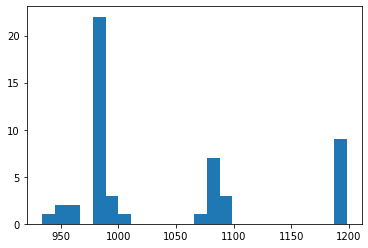

In [15]:
for i in range(10):
    print(pieceScores[i])
print(len(pieceScores))
h,numBins = histograms[pieceScores[0][0]]
showHistograms(h,numBins)

#displayHist(pieceScores, 1)

In [86]:
pieceStr = pieceScores[0][0]
midi_db_dir = 'bootleg_total\\'
midi_bscore_pkl = '{}\\{}.pkl'.format(midi_db_dir,pieceStr)
if not os.path.exists(midi_bscore_pkl):
    midi_bscore_pkl = '{}/{}.pkl'.format(midi_db_dir,'p171')
midi_d = loadMidiBootlegScore(midi_bscore_pkl)

bscore_midi, miditimes, num_notes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)
D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [8]:
def getRank(pieceScores,correctPiece):
    rank = 200
    for i in range(len(pieceScores)):
        if pieceScores[i][0]==correctPiece:
            rank=i+1
    return rank

In [81]:
getRank(pieceScores, os.path.basename(imagefile).split('_')[0])

200

### Run system on all files

In [7]:
def processSingleQuery(imagefile, rindex, counts = None, outfile = None, mode = "N_GRAM"):
    if outfile is not None and os.path.exists(outfile):
        print("SKIPPED",outfile)
        return
    profileStart = time.time()
    
    # Get Bootleg Score
    bscore_query=processQuery(imagefile)
    
    # Generate and rank histograms
    if mode == "NORMAL":
        offsetDict = getOffsetDelta(bscore_query, rindex)
    elif mode == "N_GRAM":
        offsetDict = getOffsetDeltaNGram(bscore_query, rindex, N_Gram = 3)
    elif mode == "Dynamic_Static":
        offsetDict = getOffsetDeltaDynamicStaticN_GRAM(bscore_query, rindex, Max_N=4)
    elif mode == "Dynamic_Adaptive":
        offsetDict = getOffsetDeltaDynamicAdaptiveN_GRAM(bscore_query, rindices=rindex, counts=counts, K_total=50000, Max_N=4)
    pieceScores, histograms = rankHistograms(offsetDict, rindex)
    
    # Profile & save to file
    profileEnd = time.time()
    profileDur = profileEnd - profileStart
    print(profileDur)
    saveToFile(outfile, imagefile, pieceScores, profileDur)

    return pieceScores

In [8]:
def saveToFile(outfile, imagefile, pieceScores, profileDur):
    if outfile:
        with open(outfile, 'wb') as f:
            query = os.path.splitext(os.path.basename(imagefile))[0]
            pickle.dump((query,pieceScores, profileDur),f)

In [89]:
st = time.time()
pickle_file = 'experiments/indices/3_Gram_DB.pkl'
with open(pickle_file, 'rb') as f:
    rindex1 = pickle.load(f)
print("LOADED pkl file")
rindex_filter = rindex1
print("Total Time: ",time.time()-st)

LOADED pkl file
Total Time:  43.76447153091431


In [90]:
# Condense if using selectedfp
condense = False
if condense :
    rindex_filter = copy.deepcopy(rindex1)
    for key in rindex1:
        s = 0
        for piece in rindex1[key].keys():
            s +=len(rindex1[key][piece])
        if s > 10000:
            rindex_filter.pop(key, None)
print("Total Time: ",time.time()-st)

Total Time:  400.43487334251404


In [6]:
st = time.time()
Max_N = 4
rindex_filter = []
fpMaps = []
counts = []
for i in range(1, Max_N+1):
    print("LOADING {}".format(i))
    count_file = 'G:/experiments/indices/N_GRAM_{}_COUNT.pkl'.format(i)
    with open(count_file, 'rb') as f:
        counts.append(pickle.load(f))
        f.flush()
        f.close()
print("LOADED pkl files")
print("Total Time: ",time.time()-st)

LOADING 1
LOADING 2
LOADING 3


MemoryError: 

In [ ]:
# process single query
counts = []
query_file = 'data/queries/p155_q6.jpg'
midi_bscore_path = 'experiments/test/db/'
processSingleQuery(query_file, rindex_filter, counts = counts, mode = "N_GRAM")
#cProfile.run("processSingleQuery(query_file, rindex_filter, counts = counts, mode = "N_GRAM")")

In [9]:
def processQuery_wrapper(queryfile, rindex, counts,  outdir, mode):
    # wrapper for running multiple jobs in parallel
    basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
    hyp_outfile = "{}/{}.hyp".format(outdir, basename)
    piece = basename.split('_')[0]
    return processSingleQuery(queryfile, rindex, counts, hyp_outfile, mode)

In [10]:
pickle_file = 'experiments/indices/Dynamic_N_GRAM_ALL(2).pkl'
query_list = 'cfg_files/query.test.list'
outdir = 'experiments/Analysis/test'
mode = "Dynamic_Static"

with open(pickle_file,'rb')as f:
    rindex = pickle.load(f)

In [11]:
# # process all queries
# #pickle_file = 'experiments/indices/**index.pkl'
# pickle_file = 'experiments/indices/N_GRAM_1_ALL.pkl'
# pickle_map = 'experiments/indices/N_GRAM_1_ALL_MAP.pkl'
# query_list = 'cfg_files/query.train.list' # list of query images
# outdir = 'experiments/Analysis/hyp' # where to save hypothesis output files
# mode = "Dynamic_Static"

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# # load reverse index. Recommend keeping load=False and loading it earlier.
# load = False
# if load:
#     print("LOADING RINDEX")
#     rindex1 = []
#     with open(pickle_file, 'rb') as f:
#         rindex1 = pickle.load(f)
#     with open(pickle_map, 'rb') as f:
#         fpMap = pickle.load(f)
#     condense = False
#     rindex_filter = rindex1
#     if condense :
#         rindex_filter = copy.deepcopy(rindex1)
#         for key in rindex1:
#             s = 0
#             for piece in rindex1[key].keys():
#                 s +=len(rindex1[key][piece])
#             if s > 200000:
#                 rindex_filter.pop(key, None)
# if mode == "N_GRAM":
#     counts = []

print("STARTING PROCESSING")
# number of cores to use
counts = []
multiprocess = False
if multiprocess:
    n_cores = 25 #multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=n_cores)

inputs = []
with open(query_list, 'r') as f:
    for line in f:
        inputs.append((line.rstrip(), outdir))

if multiprocess:
    # process queries in parallel
    outputs = list(pool.starmap(processQuery_wrapper, inputs))
else:
    for i in inputs:
        processQuery_wrapper(i[0],rindex, counts,i[1], mode = mode)


STARTING PROCESSING
SKIPPED experiments/Analysis/test/p2_q1.hyp
SKIPPED experiments/Analysis/test/p2_q2.hyp
SKIPPED experiments/Analysis/test/p2_q3.hyp
SKIPPED experiments/Analysis/test/p2_q4.hyp
SKIPPED experiments/Analysis/test/p2_q5.hyp
SKIPPED experiments/Analysis/test/p2_q6.hyp
SKIPPED experiments/Analysis/test/p2_q7.hyp
SKIPPED experiments/Analysis/test/p2_q8.hyp
SKIPPED experiments/Analysis/test/p2_q9.hyp
SKIPPED experiments/Analysis/test/p2_q10.hyp
SKIPPED experiments/Analysis/test/p3_q1.hyp
SKIPPED experiments/Analysis/test/p3_q2.hyp
SKIPPED experiments/Analysis/test/p3_q3.hyp
SKIPPED experiments/Analysis/test/p3_q4.hyp
SKIPPED experiments/Analysis/test/p3_q5.hyp
SKIPPED experiments/Analysis/test/p3_q6.hyp
SKIPPED experiments/Analysis/test/p3_q7.hyp
SKIPPED experiments/Analysis/test/p3_q8.hyp
SKIPPED experiments/Analysis/test/p3_q9.hyp
SKIPPED experiments/Analysis/test/p3_q10.hyp
SKIPPED experiments/Analysis/test/p4_q1.hyp
SKIPPED experiments/Analysis/test/p4_q2.hyp
SKIPPED ex